# 🗺️ Tutorial: Getting Started with Semantic Segmentation using PyTorch & SMP

## SIBGRAPI 2025 - Bahia/BA 🌴

**Authors:**

* João Fernando Mari - joaof.mari@ufv.br
* Leandro Henrique Furtado Pinto Silva - leandro.furtado@ufv.br
* Mauricio Cunha Escarpinati - mauricio@ufu.br
* André Ricardo Backes - arbackes@yahoo.com.br

## 🛠️ Importing Libraries and Setup

In [1]:
import time
import os
import sys
import argparse
import random
import pickle
import csv
import re

import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import skimage
from skimage import img_as_ubyte, img_as_float
import sklearn 
from sklearn import model_selection

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

## ⚡ Checking CUDA and Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## ⚙️ Experiment Configuration (Args)

In [3]:
# This parser is used to set the parameters for the training and evaluation.
parser = argparse.ArgumentParser()

parser.add_argument('--dataset_name', help="Name of the used dataset.", type=str, required=False, default='deepglobe')
parser.add_argument('--n_classes', help="Number of classes",  type=int, required=False, default=7)
parser.add_argument('--in_channels', help="Number of input channels",  type=int, required=False, default=3)
parser.add_argument('--h_size', help="Image height",  type=int, required=False, default=512)
parser.add_argument('--w_size', help="Image weight",  type=int, required=False, default=512)

parser.add_argument('--model', help="An SMP model.", type=str, required=False, default='Unet')
parser.add_argument('--backbone', help="A SMP backbone.", type=str, required=False, default='resnet50')
parser.add_argument('--pretrained', help="Train over a pretrained backbone. ['None', 'imagenet', ...]",  type=str, required=False, default='imagenet')
parser.add_argument('--loss', help="The loss function. ['crossentropy', 'dice', 'jaccard', ...]",  type=str, required=False, default='crossentropy')

parser.add_argument('--da_train', help="DA strategy for training. ['none', 'mild', 'moderate', 'strong']",  type=str, required=False, default='mild')
parser.add_argument('--seed', help="Seed for random number generation.", type=int, required=False, default=42)
parser.add_argument('--max_epochs', help="Maximum number of epochs.", type=int, required=False, default=200)

parser.add_argument('--batch_size', help="Batch size.", type=int, required=False, default=8)
parser.add_argument('--lr', help="Learning rate.", type=float, required=False, default=0.0001)
parser.add_argument('--weight_decay', help="Weight decay.", type=float, required=False, default=0.0004)
parser.add_argument('--scheduler', help="The scheduler strategy. ['onecycle', 'cosine', 'plateau', ...]", type=str, required=False, default='plateau')
parser.add_argument('--patience', help="Patience for early stoping.", type=int, required=False, default=21)

parser.add_argument('--save_images', help="Save the images?", required=False, default=True,  action=argparse.BooleanOptionalAction)
parser.add_argument('--segmap_mode', help="How to save seg. map when multiclass. ['simple', 'gray', 'darker']", type=str, required=False, default='simple')
parser.add_argument('--debug', help="Is running in debug mode?", required=False, default=False, action='store_true')

parser.add_argument('--use_fn', help="Use SMP preprocessing_fn?", required=False, default=False,  action=argparse.BooleanOptionalAction)
parser.add_argument('--ec', help='Experiment counter for sequential runs - ec = 0 starts a new CSV, ec > 0 appends results to the existing file.', type=int, default=0)

# Flag to perform evaluation over the validation set.
eval_val = False

# ***** IMPORTANT!!! *****
# If exporting this notebook as a .py script, comment out the line below!
# *************************
sys.argv = ['-f']

args = parser.parse_args()
    
if args.pretrained == 'None':
    args.pretrained = None

In [4]:
# If the number of classes is 2, we set it to 1 to handle binary classification properly.
# In binary segmentation tasks, the model predicts a single output channel representing the positive class.
# This simplifies the output shape and loss computation by treating the problem as one-vs-background.
# Using a single channel for the positive class is standard practice for binary masks.
if args.n_classes == 2: # Binary segmentation. Multiclass segmentation tasks have n_classes > 2.
    args.n_classes = 1

print(f'Number of classes: {args.n_classes}\nInput channels: {args.in_channels}')

Number of classes: 7
Input channels: 3


## 📁 Experiment Directory Setup

In [5]:
# This section sets the directory path for experiments based on the dataset name and other parameters.
if args.debug:
    EXP_PATH_MAIN = f'exp_debug_{args.dataset_name}'
else:
    EXP_PATH_MAIN = f'exp_{args.dataset_name}'

# Set the directory path for the current experiment.
EXP_PATH = os.path.join(
    EXP_PATH_MAIN, 
    f'exp_{args.model}_{args.backbone}_{args.loss}_{args.batch_size}_{args.lr}_{args.max_epochs}_{args.scheduler}_{args.da_train}'
)
# Create the experiment directory if it does not exist.
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

In [6]:
def get_versions():
    """
    Retrieves the versions of the main libraries used in the experiment.

    Returns:
        str: A multi-line string listing each library and its corresponding version.
    """
    versions = {
        'NumPy': np.__version__,
        'Matplotlib': matplotlib.__version__,
        'Pandas': pd.__version__,
        'PIL': PIL.__version__,
        'Scikit-image': skimage.__version__,
        'Scikit-learn': sklearn.__version__,
        'PyTorch': torch.__version__,
        'Torchvision': torchvision.__version__,
        'Albumentations': A.__version__,
        'SMP': smp.__version__,
    }

    # Format the versions into a multi-line string
    output = '\n'.join([f'{k}: {v}' for k, v in versions.items()])
    return output

def get_args(args):
    """
    Formats all attributes of an argparse.Namespace into a readable string.

    Args:
        args (Namespace): An object containing experiment parameters.

    Returns:
        str: A multi-line string listing each argument name and its value.
    """
    args_str = ''
    for arg in vars(args):
        value = getattr(args, arg)
        args_str += f'{arg}: {value}\n'

    return args_str

args_str = get_args(args)
versions_str = get_versions()

print('Package versions:\n----------------------------')
print(versions_str)
print('\n\nArguments:\n----------------------------')
print(args_str)

with open(os.path.join(EXP_PATH, f'general_report.txt'), 'w') as model_file:
    model_file.write('\n\nPackage versions:\n----------------------------\n')
    model_file.write(get_versions())
    model_file.write('\n\nArguments:\n----------------------------\n')
    model_file.write(args_str)  

Package versions:
----------------------------
NumPy: 2.2.6
Matplotlib: 3.10.6
Pandas: 2.3.2
PIL: 11.3.0
Scikit-image: 0.25.2
Scikit-learn: 1.7.1
PyTorch: 2.8.0+cu128
Torchvision: 0.23.0+cu128
Albumentations: 2.0.8
SMP: 0.5.0


Arguments:
----------------------------
dataset_name: deepglobe
n_classes: 7
in_channels: 3
h_size: 512
w_size: 512
model: Unet
backbone: resnet50
pretrained: imagenet
loss: crossentropy
da_train: mild
seed: 42
max_epochs: 200
batch_size: 8
lr: 0.0001
weight_decay: 0.0004
scheduler: plateau
patience: 21
save_images: True
segmap_mode: simple
debug: False
use_fn: False
ec: 0



## 🔒 Reproducibility Settings

In [7]:
def set_seed(seed=42):
    """
    Sets random seeds for reproducibility across Python, NumPy, and PyTorch.

    Args:
        seed (int): The seed value to ensure deterministic behavior.

    Notes:
        - This function is intended to maximize reproducibility but may reduce training performance.
        - The `CUBLAS_WORKSPACE_CONFIG` environment variable is needed for CUDA >= 10.2.
        - Some models (e.g., PSPNet from SMP) may require non-deterministic algorithms and could fail with `torch.use_deterministic_algorithms(True)`
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If you use multi-GPU

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # For CUDA >= 10.2

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    torch.use_deterministic_algorithms(True, warn_only=True)

# Set the seeds
set_seed(42)

## 🗂️ Datasets Definition

In [8]:
class DeepGlobeDataset(Dataset):
    """
    PyTorch Dataset class for the DeepGlobe Land Cover Classification Challenge.

    This dataset loads RGB satellite images and their corresponding multi-class masks,
    converting mask colors to class indices.

    Args:
        ds_dir (str): Path to the dataset folder containing images and masks.
        image_filenames (list[str]): List of image filenames (.jpg).
        mask_filenames (list[str]): List of mask filenames (.png).
        transform (callable, optional): Optional transform to be applied on image and mask (e.g., Albumentations).

    Attributes:
        rgb_to_class (dict): Mapping from RGB color tuples to class indices.
        class_to_rgb (dict): Reverse mapping from class indices to RGB color tuples (useful for visualization).
    """
    
    def __init__(self, ds_dir, image_filenames, mask_filenames, transform=None):
        self.ds_dir = ds_dir
        self.transform = transform
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames

        # Define RGB-to-class index mapping
        self.rgb_to_class = {
            (0, 255, 255): 0,    # Urban land
            (255, 255, 0): 1,    # Agriculture land
            (255, 0, 255): 2,    # Rangeland
            (0, 255, 0): 3,      # Forest land
            (0, 0, 255): 4,      # Water
            (255, 255, 255): 5,  # Barren land
            (0, 0, 0): 6         # Unknown (Clouds & others)
        }

        # Inverse mapping: class index to RGB (for visualization)
        self.class_to_rgb = {v: k for k, v in self.rgb_to_class.items()}

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Loads an image-mask pair, converts the mask to class indices, and applies transforms.

        Args:
            idx (int): Index of the sample.

        Returns:
            image (torch.Tensor or np.ndarray): Transformed image.
            mask (torch.Tensor or np.ndarray): Transformed mask with class indices.
            img_path (str): Path to the original image file.
        """
        img_name = self.image_filenames[idx]
        mask_name = self.mask_filenames[idx]

        # Check if the image and mask filenames share the same prefix
        if img_name.split('_')[0] != mask_name.split('_')[0]:
            print(f"Warning! The image and mask files do not match! {img_name} != {mask_name}")

        img_path = os.path.join(self.ds_dir, img_name)
        mask_path = os.path.join(self.ds_dir, mask_name)  

        # Load image and mask (as RGB)
        image = np.array(Image.open(img_path).convert("RGB"))  # Ensure 3-channel RGB
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))  # Read mask as RGB

        # Convert RGB mask to class index mask
        mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)  #
        for rgb, class_idx in self.rgb_to_class.items():
            # Assign class index to corresponding pixels
            mask[(mask_rgb == rgb).all(axis=-1)] = class_idx  

        # Apply augmentations if defined
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        else:
            # Ensure float32 in [0, 1] and Tensor format (C, H, W)
            image = torch.from_numpy(img_as_float(image)).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask, img_path

In [9]:
class CloudDataset(Dataset):
    """
    PyTorch Dataset for loading multi-band satellite images and corresponding masks.

    This dataset assumes the following folder structure inside `ds_path`:
        - train_red/
        - train_green/
        - train_blue/
        - train_nir/
        - train_gt/

    Each band image is named following the pattern: <band>_<filename>.TIF

    Reference:
        https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf

    Args:
        ds_path (str): Path to the dataset root directory.
        file_list (list[str]): List of filenames (without extension or band prefix).
        transform (callable, optional): A function/transform to apply on both image and mask.

    Returns:
        image (torch.Tensor): Transformed image.
        mask (torch.Tensor): Transformed mask.
        img_path (str): Path to the red channel image file.
    """

    def __init__(self, ds_path, file_list, transform=None):
        super().__init__()

        self.transform = transform
        
        # Build the paths for the images
        red_path = os.path.join(ds_path, "train_red")
        green_path = os.path.join(ds_path, "train_green")
        blue_path = os.path.join(ds_path, "train_blue")
        nir_path = os.path.join(ds_path, "train_nir")
        gt_path = os.path.join(ds_path, "train_gt")

        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(file_, 
                                         red_path, 
                                         green_path, 
                                         blue_path, 
                                         nir_path, 
                                         gt_path) for file_ in file_list]

    def combine_files(self, file, red_dir, green_dir, blue_dir, nir_dir, gt_dir):
        """
        Builds a dictionary mapping band names to their file paths.

        Args:
            file (str): Base filename (without band prefix).
            *_dir (str): Directory path for each band.

        Returns:
            dict: Dictionary with keys ['red', 'green', 'blue', 'nir', 'gt'] mapped to file paths.
        """
        bands = {
            'red': red_dir,
            'green': green_dir,
            'blue': blue_dir,
            'nir': nir_dir,
            'gt': gt_dir
        }
        return {band: os.path.join(dir_, f'{band}_{file}.TIF') for band, dir_ in bands.items()}
                                       
    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.files)
    
    def open_image(self, idx, include_nir=False):
        """
        Loads and stacks RGB bands (optionally with NIR), converting to 8-bit.

        Args:
            idx (int): Index of the sample.
            include_nir (bool): Whether to include the NIR channel.

        Returns:
            np.ndarray: Multi-channel image (H, W, C).
        """
        # Load RGB channels and stack them
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])), ], axis=2)
    
        # Optionally append the NIR channel
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        # Convert 16-bit original images to 8-bit for processing
        raw_rgb = img_as_ubyte(raw_rgb)

        return raw_rgb
    
    def open_mask(self, idx):
        """
        Loads the mask, binarizing it into 0 (background) and 1 (cloud).

        Args:
            idx (int): Index of the sample.
            add_dims (bool): Whether to add a channel dimension (for compatibility with transforms).

        Returns:
            np.ndarray: Binary mask.
        """
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return raw_mask
    
    def __getitem__(self, idx):
        # Load image with RGB + NIR bands
        image = self.open_image(idx, include_nir=True)
        # Load corresponding binary mask
        mask = self.open_mask(idx)

        img_path = str(self.files[idx]['red'])

        # Apply data augmentation if provided
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        else:
            # Ensure float32 in [0, 1] and Tensor format (C, H, W)
            image = torch.from_numpy(img_as_float(image)).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        # Retorn the image, mask and the file path. 
        return image, mask, img_path

In [10]:
class FusarMapDataset(Dataset):
    """
    PyTorch Dataset class for grayscale image segmentation with multiclass masks (5 classes).

    Args:
        ds_dir (str): Path to the dataset folder containing images and masks.
        image_filenames (list[str]): List of image filenames (e.g., .png, .jpg).
        mask_filenames (list[str]): List of corresponding mask filenames (.png).
        transform (callable, optional): Optional Albumentations transform applied to both image and mask.
    """

    def __init__(self, ds_dir, image_filenames, mask_filenames, transform=None):
        self.ds_dir = ds_dir
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

        self.rgb_to_class = {
            (0, 0, 0):     0,   # black   - unknown/background
            (255, 0, 0):   1,   # red     - building 
            (0, 255, 0):   2,   # green   - vegetation 
            (0, 0, 255):   3,   # blue    - water
            (255, 255, 0): 4    # yellow  - road 
        }

        # Inverse mapping: class index to RGB (for visualization)
        self.class_to_rgb = {v: k for k, v in self.rgb_to_class.items()}

    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        mask_name = self.mask_filenames[idx]

        # Check filename match (optional)
        # Image: XiaMen_02_01_03_02_SAR_097.tif | Mask: XiaMen_02_01_03_02_Label_097.tif
        if re.sub(r'(SAR|Label)', '', img_name) != re.sub(r'(SAR|Label)', '', mask_name):
            print(f"Warning: Mismatch between image and mask names: {img_name} vs. {mask_name}")

        img_path = os.path.join(self.ds_dir, 'SAR_1024', img_name)
        mask_path = os.path.join(self.ds_dir, 'LAB_1024', mask_name)

        # Load grayscale image and mask
        image = np.array(Image.open(img_path).convert("L"))  # (H, W), grayscale
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))  # Read mask as RGB

        # Convert RGB mask to class index mask
        mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8) 
        for rgb, class_idx in self.rgb_to_class.items():
            # Assign class index to corresponding pixels
            mask[(mask_rgb == rgb).all(axis=-1)] = class_idx  

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            # Normalize to [0, 1] and convert to tensor with shape (1, H, W)
            image = torch.from_numpy(img_as_float(image)).unsqueeze(0).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask, img_path

## 🧩 Model Definition and Initialization

In [11]:
def init_model(model_name, backbone, in_channels, n_classes, pretrained="imagenet"):
    """
    Initializes a segmentation model from the Segmentation Models PyTorch (SMP) library
    along with its corresponding preprocessing function.

    Args:
        model_name (str): Name of the segmentation architecture. 
        backbone (str): Encoder backbone name.
        in_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB+NIR).
        n_classes (int): Number of output classes.
        pretrained (str, optional): Pretrained weights to load into the encoder. 
            Common options: 'imagenet', 'ssl', or None. Default is 'imagenet'.

    Returns:
        model (nn.Module): Instantiated SMP model ready for training.
        preprocessing_fn (callable): Function to apply encoder-specific preprocessing on input images.

    Raises:
        ValueError: If the given `model_name` is not supported.
    """
    # Map model names to their constructors in SMP
    model_map = {
        "Unet": smp.Unet,
        "Unet++": smp.UnetPlusPlus,
        "MAnet": smp.MAnet,
        "Linknet": smp.Linknet,
        "FPN": smp.FPN,
        "PSPNet": smp.PSPNet,
        "PAN": smp.PAN,
        "DeepLabV3": smp.DeepLabV3,
        "DeepLabV3+": smp.DeepLabV3Plus,
        "Segformer": smp.Segformer,
    }

    # Check for valid model
    if model_name not in model_map:
        raise ValueError(f"Model '{model_name}' is not supported.")

    # Instantiate the model with the specified parameters
    model = model_map[model_name](
        encoder_name=backbone,
        encoder_weights=pretrained,
        in_channels=in_channels,
        classes=n_classes,
    )

    # Retrieve the preprocessing function based on the encoder and pretrained weights
    preprocessing_fn = smp.encoders.get_preprocessing_fn(backbone, pretrained)

    return model, preprocessing_fn

In [12]:
# Initialize the selected SMP segmentation model and its encoder-specific preprocessing function.
# Move the model to the selected device (CPU or GPU).
model, preprocessing_fn = init_model(
    args.model, args.backbone, args.in_channels, args.n_classes, pretrained=args.pretrained
)
model.to(device)
### print(model)

print(preprocessing_fn)

# Save the model architecture summary to a text file.
with open(os.path.join(EXP_PATH, 'model.txt'), 'w') as model_file:
    model_file.write(str(model))

functools.partial(<function preprocess_input at 0x7b2a2c709120>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


## 📦 Dataset Preparation and Preprocessing

### ℹ️ Normalization Parameters (ImageNet Statistics)

In [13]:
# Mean and Standard Deviation of the ImageNet dataset.
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# For other Pretrained Weights, use the preprocessing function provided by SMP, or the provided mean and std values.
# ------
# SSL, SWSL and Instagram are the same as ImageNet.
# ImageNet+5k
### MEAN = [0.48627450980392156, 0.4588235294117647, 0.40784313725490196]
### STD = [0.23482446870963955, 0.23482446870963955, 0.23482446870963955]
# ImageNet+Background and AdvPRop
### MEAN = [0.5, 0.5, 0.5]
### STD = [0.5, 0.5, 0.5]

### 📊 Compute Per-Channel Stats for Multispectral Images

In [14]:
def compute_mean_std(dataset):
    """
    Compute per-channel mean and std over a dataset of images.
    
    Args:
        dataset (torch.utils.data.Dataset): Must return images as torch.Tensor in shape (C, H, W), normalized in [0, 1].
    
    Returns:
        (list, list): Mean and std as lists of floats (one per channel).
    """
    sum_channels = 0.0
    sum_squared_channels = 0.0
    num_pixels = 0

    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    for images, _, *_ in loader:
        b, c, h, w = images.shape
        images = images.float()
        sum_channels += images.sum(dim=[0, 2, 3])
        sum_squared_channels += (images ** 2).sum(dim=[0, 2, 3])
        num_pixels += b * h * w

    mean = sum_channels / num_pixels
    std = torch.sqrt((sum_squared_channels / num_pixels) - mean ** 2)

    mean = [round(m.item(), 3) for m in mean]
    std = [round(s.item(), 3) for s in std]

    return mean, std

### 🔄 Data Augmentation Strategies

In [15]:
def get_da(strategy='none', 
           in_channels=3,
           preprocessing_fn=None, 
           mean=[0.485, 0.456, 0.406], 
           std=[0.229, 0.224, 0.225],
           seed=42):
    """
        Builds an Albumentations transformation pipeline based on the chosen strategy.

        This function defines data augmentation and preprocessing pipelines for training, validation, and testing.
        It applies optional SMP preprocessing or standard normalization, and always finishes with `ToTensorV2()`.

        Args:
            strategy (str): Data augmentation strategy. One of:
                - 'none'  — No augmentation (training without DA).
                - 'val'   — Validation preprocessing (no augmentation).
                - 'test'  — Test preprocessing (no augmentation).
                - 'mild'  — Mild augmentation for training.
                - 'moderate' — Moderate augmentation for training.
                - 'strong' — Strong augmentation for training.
            in_channels (int): Number of input channels. Used to avoid color transforms on multispectral images.
            preprocessing_fn (callable or None): If provided, applies this function for SMP-based preprocessing instead of standard normalization.
            mean (list of floats): Mean values for normalization. Should match the number of image channels.
            std (list of floats): Standard deviation values for normalization. Should match the number of image channels.
            seed (int): The seed value to ensure deterministic behavior.

        Returns:
            A.Compose: The composed Albumentations transformation pipeline.

        Notes:
            - If `preprocessing_fn` is provided and `in_channels > 3`, `mean` and `std` must have matching lengths.
            - CLAHE and HueSaturationValue are skipped for multispectral and grayscale images (2 < in_channels > 3).
            - HueSaturationValue is skipped for grayscale images (in_channels == 13).
        """
            
    if strategy == 'none' or strategy == 'val' or strategy == 'test':
        # Transformation for training without data augmentation or validation/test. 
        # No data augmentation is applied here.
        t = [
            A.Resize(args.h_size, args.w_size),
        ]

    elif strategy == 'mild':
        # Transformations for training. Mild data augmentation is applied here.
        t = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Affine(
                translate_percent=0.05, scale=(0.9, 1.1), rotate=(-20, 20), p=0.5
            ),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.Resize(args.h_size, args.w_size),
        ]

    elif strategy == 'moderate':
        # Transformations for training. Moderate data augmentation is applied here.
        t = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Affine(
                translate_percent=0.05, scale=(0.9, 1.1), rotate=(-20, 20), p=0.5
            ),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        ]
        if in_channels > 1 and in_channels < 4: # HueSaturationValue: apply only over RGB images
            t += [
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)
            ]
        t += [
            A.GaussNoise(p=0.3),
            A.Resize(args.h_size, args.w_size),
        ]

    elif strategy == 'strong':
        # Transformations for training. Strong data augmentation is applied here.
        t = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Affine(
                translate_percent=0.05, scale=(0.9, 1.1), rotate=(-20, 20), p=0.5
            ),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
        ]
        if in_channels > 1 and in_channels < 4: # HueSaturationValue: apply only over RGB images
            t += [
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)
            ]
        t += [
            A.OneOf([
                A.ElasticTransform(alpha=1, sigma=50, p=0.5),
                A.GridDistortion(p=0.5),
                A.OpticalDistortion(distort_limit=1.0, p=0.5),
            ], p=0.5),
            A.GaussNoise(p=0.3),
        ]
        if in_channels < 4: # Avoid CLAHE for multispectral images
            t += [A.CLAHE(clip_limit=4.0, p=0.4)]
        t += [A.Resize(args.h_size, args.w_size)]

    # Apply preprocessing: either SMP preprocessing_fn or standard normalization
    if preprocessing_fn is not None:
        print('Appliyng SMP preprocessing_fn...')
        t.append(A.Lambda(image=preprocessing_fn))
    else:
        print('Applying A.Normalize...')
        t.append(A.Normalize(mean=mean, std=std))

    # Convert to PyTorch Tensor 
    t.append(ToTensorV2())

    # Print the transformations
    ### print(*t, sep='\n')

    t = A.Compose(t, seed=seed)

    return t

## 🗂️ Datasets Loading and Spliting

In [16]:
def split_dataset(image_filenames, mask_filenames, val_size=0.2, test_size=0.2, random_state=42):
    """
    Splits paired image and mask filenames into training, validation, and test sets.

    This function assumes that corresponding images and masks remain aligned across splits.

    Args:
        image_filenames (list[str]): List of image file paths.
        mask_filenames (list[str]): List of corresponding mask file paths.
        val_size (float, optional): Proportion of the dataset to include in the validation split. Default is 0.15.
        test_size (float, optional): Proportion of the dataset to include in the test split. Default is 0.15.
        random_state (int, optional): Seed for the random number generator to ensure reproducibility.

    Returns:
        train_images (list[str])
        train_masks (list[str])
        val_images (list[str])
        val_masks (list[str])
        test_images (list[str])
        test_masks (list[str])

    Raises:
        AssertionError: If image_filenames and mask_filenames lists have different lengths.
    """
    assert len(image_filenames) == len(mask_filenames), "Image and mask lists must be the same length."

    val_test_size = val_size + test_size

    pairs = list(zip(image_filenames, mask_filenames))

    # First split: train and temp (val+test)
    train_pairs, temp_pairs = model_selection.train_test_split(
        pairs, test_size=val_test_size, random_state=random_state)

    # Split temp into val and test
    val_ratio = val_size / val_test_size
    val_pairs, test_pairs = model_selection.train_test_split(
        temp_pairs, test_size=(1 - val_ratio), random_state=random_state)

    # Unzip
    train_images, train_masks = zip(*train_pairs)
    val_images, val_masks = zip(*val_pairs)
    test_images, test_masks = zip(*test_pairs)

    return list(train_images), list(train_masks), \
           list(val_images), list(val_masks), \
           list(test_images), list(test_masks)

### 🌎 DeepGlobe Dataset

In [17]:
if args.dataset_name == 'deepglobe':
    DS_PATH = os.path.expanduser('~/Datasets/DeepGlobe/train')
    # List all satellite images (JPG) and masks (PNG) in the dataset folder
    image_filenames = sorted([f for f in os.listdir(DS_PATH) if f.endswith('.jpg')])
    mask_filenames = sorted([f for f in os.listdir(DS_PATH) if f.endswith('.png')])

    train_images, train_masks, val_images, val_masks, test_images, test_masks = \
        split_dataset(image_filenames, mask_filenames, val_size=0.2, test_size=0.2, random_state=42)

### ☁️ 38-Cloud Dataset

In [18]:
if args.dataset_name == '38-cloud':
    DS_PATH = os.path.expanduser('~/Datasets/38-Cloud/38-Cloud_training/')
    # All satellite images are jpg files
    df_train = pd.read_csv(
        os.path.join(DS_PATH, 'training_patches_38-Cloud.csv'), 
        skiprows=1, 
        header=None, 
        names=['id'
    ])

    # Define split proportions for validation and test sets
    val_size = 0.2
    test_size = 0.2
    total_size = val_size + test_size

    # Split temporary set into validation and test sets
    train_paths, temp_pairs = model_selection.train_test_split(
        df_train['id'].values, 
        test_size=total_size, 
        random_state=42
    )

    # Split temp into val and test
    val_ratio = val_size / total_size
    val_paths, test_paths = model_selection.train_test_split(
        temp_pairs, 
        test_size=(1 - val_ratio), 
        random_state=42
    )

### 🛰️ FUSAR-Map Dataset

In [19]:
if args.dataset_name == 'FUSAR-Map':
    DS_PATH = os.path.expanduser('~/Datasets/FUSAR-Map/FUSAR-Map1.0/FUSAR-Map/')
    # List all SAR images and masks from the respective folders
    image_filenames = sorted([f for f in os.listdir(os.path.join(DS_PATH, 'SAR_1024')) if f.endswith('.tif')])
    mask_filenames = sorted([f for f in os.listdir(os.path.join(DS_PATH, 'LAB_1024')) if f.endswith('.tif')])

    train_images, train_masks, val_images, val_masks, test_images, test_masks = \
        split_dataset(image_filenames, mask_filenames, val_size=0.2, test_size=0.2, random_state=42)

### 🧹 Datasets Preprocessing

In [20]:
if args.in_channels > 3:
    # For multispectral images, we need to compute the mean and std for the extra channels.
    # Only 38-Cloud is multispectral.
    train_dataset = CloudDataset(DS_PATH, train_paths)

    # Compute mean ans standard deviation for the extra channels. 
    # Only for multispectral images.
    mean_ds, std_ds = compute_mean_std(train_dataset)
    ### print(mean_ds, std_ds)

    # Merge pretraining stats with dataset-specific stats
    MEAN = MEAN + mean_ds[3:]
    STD = STD + std_ds[3:]

elif args.in_channels < 3:
    # For grayscale images
    MEAN = MEAN[:args.in_channels]
    STD = STD[:args.in_channels]

print(f'Mean: {MEAN}')
print(f'Std Dev: {STD}')

Mean: [0.485, 0.456, 0.406]
Std Dev: [0.229, 0.224, 0.225]


In [21]:
def multispectral_preprocessing(preprocessing_fn, extra_mean, extra_std):
    """
    Creates a preprocessing function for multispectral images with RGB + extra channels.

    This wrapper function applies the SMP-provided preprocessing (mean/std normalization)
    to the first 3 channels (assumed to be RGB) using `preprocessing_fn`.  
    The remaining channels are normalized manually using the provided `extra_mean` and `extra_std`.  

    The returned function is compatible with Albumentations' `A.Lambda()`.  

    Args:
        preprocessing_fn (callable): Preprocessing function from SMP to apply on RGB channels.
        extra_mean (list or tuple of floats): Mean values for **all channels** (including RGB).
        extra_std (list or tuple of floats): Standard deviation values for **all channels** (including RGB).

    Returns:
        callable: Function that applies preprocessing on a single image, accepting **kwargs
                  for compatibility with Albumentations.

    Raises:
        ValueError: If `extra_mean` or `extra_std` length does not match the number of image channels.
    """
    def process(img, **kwargs):
        img = img.copy()
        num_channels = img.shape[2]

        # Validate that the provided mean and std cover all image channels
        if len(extra_mean) != num_channels:
            raise ValueError(f"Length of extra_mean ({len(extra_mean)}) does not match number of channels ({num_channels}).")
        if len(extra_std) != num_channels:
            raise ValueError(f"Length of extra_std ({len(extra_std)}) does not match number of channels ({num_channels}).")

        # Apply SMP preprocessing for first 3 channels (RGB)
        img[:, :, 0:3] = preprocessing_fn(img[:, :, 0:3].astype(np.float32))
        # Manually normalize each extra channel (from index 3 to N)
        for c in range(3, num_channels):
            img[:, :, c] = (img[:, :, c] - extra_mean[c]) / extra_std[c]
        return img

    return process

if args.in_channels > 3:
    preprocessing_fn = multispectral_preprocessing(preprocessing_fn, MEAN, STD )

In [22]:
if args.use_fn:
    t_train = get_da(args.da_train, args.in_channels, preprocessing_fn)
    t_val = get_da('val', args.in_channels, preprocessing_fn)
    t_test = get_da('test', args.in_channels, preprocessing_fn)

else:
    t_train = get_da(args.da_train, args.in_channels, mean=MEAN, std=STD)
    t_val = get_da('val', args.in_channels, mean=MEAN, std=STD)
    t_test = get_da('test', args.in_channels, mean=MEAN, std=STD)

Applying A.Normalize...
Applying A.Normalize...
Applying A.Normalize...


### 🗂️ Datasets

In [23]:
if args.dataset_name == 'deepglobe':
    # Create dataset instances with the respective transformations
    train_dataset = DeepGlobeDataset(DS_PATH, train_images, train_masks, transform=t_train)
    val_dataset = DeepGlobeDataset(DS_PATH, val_images, val_masks, transform=t_val)
    test_dataset = DeepGlobeDataset(DS_PATH, test_images, test_masks, transform=t_test)

    # Retrieve color coding dictionary (used for mask visualization)
    class_to_rgb = train_dataset.class_to_rgb

    if args.debug:
        # Reduce dataset size for debugging and faster iteration
        train_dataset = torch.utils.data.Subset(train_dataset, range(len(train_dataset)//4))
        val_dataset  = torch.utils.data.Subset(val_dataset, range(len(val_dataset)//4))
        test_dataset  = torch.utils.data.Subset(test_dataset, range(len(test_dataset)//4))

    print(f"Dataset sizes:\nTrain: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Dataset sizes:
Train: 481 | Val: 161 | Test: 161


In [24]:
if args.dataset_name == '38-cloud':
    # Instantiate datasets with corresponding transformations
    train_dataset = CloudDataset(DS_PATH, train_paths, transform=t_train)
    val_dataset = CloudDataset(DS_PATH, val_paths, transform=t_val)
    test_dataset = CloudDataset(DS_PATH, test_paths, transform=t_test)

    print(f"Dataset sizes:\nTrain: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

In [25]:
if args.dataset_name == 'FUSAR-Map':
    # Create dataset instances with the respective transformations
    train_dataset = FusarMapDataset(DS_PATH, train_images, train_masks, transform=t_train)
    val_dataset = FusarMapDataset(DS_PATH, val_images, val_masks, transform=t_val)
    test_dataset = FusarMapDataset(DS_PATH, test_images, test_masks, transform=t_test)

    # Retrieve color coding dictionary (used for mask visualization)
    class_to_rgb = train_dataset.class_to_rgb

    print(f"Dataset sizes:\nTrain: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

    if args.debug:
        # Reduce dataset size for debugging and faster iteration
        train_dataset = torch.utils.data.Subset(train_dataset, range(len(train_dataset)//16))
        val_dataset  = torch.utils.data.Subset(val_dataset, range(len(val_dataset)//32))
        test_dataset  = torch.utils.data.Subset(test_dataset, range(len(test_dataset)//32))

    print(f"Dataset sizes:\nTrain: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Image Size: (2448, 2448, 3) uint8 0 255
Mask Size: (2448, 2448, 3) uint8 0 255


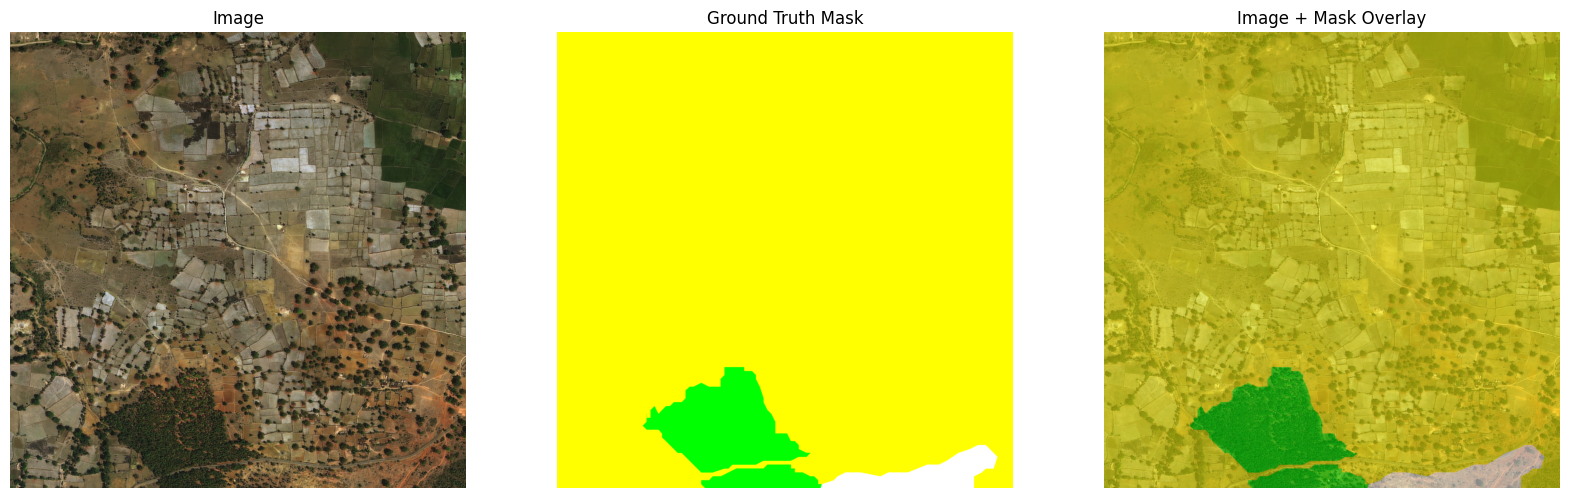

In [26]:
def save_sample_visualization(ds, train_path, exp_path, file_list=None, idx=100):
    """
    Visualizes and saves an image-mask pair from the dataset.

    This function creates a figure with:
        - The original image
        - The ground truth mask
        - The overlay of the mask on the image

    Saves the figure both as PNG and PDF in the experiment folder.

    Args:
        ds (str): Dataset name. Supported: 'deepglobe', '38-cloud'.
        train_path (str): Path to the dataset folder.
        exp_path (str): Path to the experiment folder where the figure will be saved.
        file_list (list[str], optional): List of filenames (without extension) for '38-cloud'. Not required for 'deepglobe'.
        idx (int, optional): Index of the sample to visualize. Default is 100.

    Raises:
        ValueError: If `ds` is not one of the supported datasets.
    """
    if ds == 'deepglobe':
        image_dir = train_path
        mask_dir = train_path
        # Files are stored together with jpg images and png masks
        images_list = sorted([f for f in os.listdir(DS_PATH) if f.endswith('.jpg')])
        masks_list = sorted([f for f in os.listdir(DS_PATH) if f.endswith('.png')])

        img_rgb = Image.open(os.path.join(image_dir, images_list[idx]))
        img_rgb = img_as_ubyte(img_rgb)

        mask = np.array(Image.open(os.path.join(mask_dir, masks_list[idx])))
        
    elif ds == '38-cloud':
        if file_list is None:
            raise ValueError("For '38-cloud', file_list must be provided.")
        
        # Get sorted paths for each band and mask
        images_red_list = sorted([os.path.join(train_path, "train_red", 'red_' + f + '.TIF') for f in file_list])
        images_green_list = sorted([os.path.join(train_path, "train_green", 'green_' + f + '.TIF') for f in file_list])
        images_blue_list = sorted([os.path.join(train_path, "train_blue", 'blue_' + f + '.TIF') for f in file_list])
        images_gt_list = sorted([os.path.join(train_path, "train_gt", 'gt_' + f + '.TIF') for f in file_list])

        print(len(images_red_list))

        img_rgb = np.stack([np.array(Image.open(os.path.join(train_path, 'train_red', images_red_list[idx]))),
                            np.array(Image.open(os.path.join(train_path, 'train_green', images_green_list[idx]))),
                            np.array(Image.open(os.path.join(train_path, 'train_blue', images_blue_list[idx]))), ], axis=2)

        # Convert from 16 bit to 8 bit
        img_rgb = img_as_ubyte(img_rgb)

        mask = np.array(Image.open(os.path.join(train_path, 'train_gt', images_gt_list[idx])))

    elif ds == 'FUSAR-Map':
        image_list = sorted([f for f in os.listdir(os.path.join(DS_PATH, 'SAR_1024')) if f.endswith('.tif')])
        mask_list = sorted([f for f in os.listdir(os.path.join(DS_PATH, 'LAB_1024')) if f.endswith('.tif')])

        # Load grayscale image and mask
        img_rgb = np.array(Image.open(os.path.join(train_path, 'SAR_1024', image_list[idx])).convert("L"))  # (H, W), grayscale
        ### mask = np.array(Image.open(mask_path).convert("L"))  # (H, W), binary mask
        mask = np.array(Image.open(os.path.join(train_path, 'LAB_1024', mask_list[idx])).convert("RGB"))  # Read mask as RGB
   
    # Show info
    print('Image Size:', img_rgb.shape, img_rgb.dtype, img_rgb.min(), img_rgb.max())
    print('Mask Size:', mask.shape, mask.dtype, mask.min(), mask.max())

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(img_rgb, cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(img_rgb, cmap='gray')
    axes[2].imshow(mask, alpha=0.5)
    axes[2].set_title('Image + Mask Overlay')
    axes[2].axis('off')

    # Save figure
    os.makedirs(exp_path, exist_ok=True)
    fig.savefig(os.path.join(exp_path, 'sample_pair.png'), bbox_inches='tight')
    fig.savefig(os.path.join(exp_path, 'sample_pair.pdf'), bbox_inches='tight')
    ### plt.close(fig)

# For '38-cloud', pass the list of training filenames (required for loading multi-band images).
if args.dataset_name == '38-cloud':
    file_list = train_paths
elif args.dataset_name == 'FUSAR-Map':
    file_list = train_images
else:
    file_list = None

save_sample_visualization(args.dataset_name, train_path=DS_PATH, exp_path=EXP_PATH, file_list=file_list, idx=100)

## 📦 Data Loaders

In [27]:
g = torch.Generator().manual_seed(42)

# DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=0,
    generator=g
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=args.batch_size, 
    shuffle=False, 
    num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=args.batch_size, 
    shuffle=False, 
    num_workers=0
)

## 🏋️ Model Training

### 💢 Loss Functions

In [28]:
# Mapping loss function names to their corresponding SMP constructors
losses_map = {
    "jaccard": smp.losses.JaccardLoss,
    "dice": smp.losses.DiceLoss,
    "tversky": smp.losses.TverskyLoss,
    "focal": smp.losses.FocalLoss,
    "lavosz": smp.losses.LovaszLoss,
    # Cross-entropy handled separately due to its implementation differences in SMP
    # smp.losses.SoftBCEWithLogitsLoss and smp.losses.SoftCrossEntropyLoss,
}

if args.loss == 'crossentropy':
    if args.n_classes == 1:
        # Binary segmentation task — Using SoftBCEWithLogitsLoss
        criterion = smp.losses.SoftBCEWithLogitsLoss()
    else:
        # Multiclass segmentation task — Using SoftCrossEntropyLoss
        criterion = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.0)
else:
    # Other losses: Jaccard, Dice, Tversky, Focal, Lovasz
    if args.n_classes == 1:
        criterion = losses_map[args.loss](
            mode='binary',
            from_logits=True
        )
    else:
        criterion = losses_map[args.loss](
            mode='multiclass',
            from_logits=True,
        )

### ⚙️ Optimizer

In [29]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=args.lr, 
    weight_decay=args.weight_decay
)

### 📉 Learning Rate Scheduler

In [30]:
if args.scheduler == 'onecycle':
    # OneCycleLR requires steps_per_epoch and max_lr explicitly defined
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=args.lr, 
        epochs=args.max_epochs,
        steps_per_epoch=len(train_loader)
    )
    
elif args.scheduler == 'cosine':
    # CosineAnnealingLR reduces the LR following a cosine schedule over T_max epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=(args.max_epochs), 
        eta_min=0,
        last_epoch=-1
    )

elif args.scheduler == 'plateau':
    # ReduceLROnPlateau adjusts the LR based on monitored metric (validation loss)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
    )

else:
    raise ValueError(
        f"Learning rate scheduler '{args.scheduler}' is not supported.\n"
        f"Supported options: 'onecycle', 'cosine', 'plateau'.\n"
        f"See: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate "
        f"for all available schedulers."
    )

### 📋 Update the General Report

In [31]:
with open(os.path.join(EXP_PATH,  'general_report.txt'), 'a') as file:
    file.write(f"\n\nCriterion:\n")
    file.write(str(criterion))
    file.write(f"\n\nOptimizer:\n")
    file.write(str(optimizer))
    file.write(f"\n\nScheduler:\n")
    file.write(str(scheduler))

### 🏋️ Model Training/Validation Loop

In [32]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    """
    Trains and validates a segmentation model for a specified number of epochs.

    Args:
        epochs (int): Total number of epochs to train.
        model (nn.Module): The segmentation model.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (callable): Loss function to optimize.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.

    Returns:
        dict: Dictionary containing training history with keys:
            - 'train_loss', 'val_loss'
            - 'train_iou_smp', 'val_iou_smp'
            - 'train_f1_smp', 'val_f1_smp'
            - 'train_acc_smp', 'val_acc_smp'
            - 'lrs' (learning rates)
            - 'best_epoch' (epoch with best validation loss)
            - 'total_time' (training time in minutes)

    Notes:
        - Supports both binary and multiclass segmentation tasks.
        - Uses segmentation_models_pytorch (SMP) metrics for evaluation.
        - Implements early stopping based on validation loss.
        - Adapts learning rate scheduling for OneCycle, Cosine, or Plateau schedulers.
        - Saves the best model checkpoint based on validation loss.
        - Compatible with debug mode for detailed shape and dtype checks.
    """

    torch.cuda.empty_cache()

    # Lists to store training and validation metrics
    train_loss_list, val_loss_list = [], []
    train_acc_smp_list, train_iou_smp_list, train_f1_smp_list = [], [], []
    val_acc_smp_list, val_iou_smp_list, val_f1_smp_list = [], [], []
    lr_list = []

    # Early stopping control
    min_loss = np.inf
    not_improve = 0
    best_epoch = None
    
    fit_time = time.time()

    def preprocess_mask(mask, n_classes):
        """Mask preprocessing helper (binary or multiclass)."""
        if n_classes == 1: 
            # Binary mode. Mask should be (B, 1, H, W) with dtype float.
            if mask.ndim == 3: # if (B, H, W) -> (B, 1, H, W)
                mask = mask.unsqueeze(1) 
            mask = mask.float() # Ensure dtype if float. Needed for some losses (e.g., BCE)
        else: 
            # Multiclass mode. Mask should be (B, H, W) with dtype long.
            if mask.ndim == 4: # if (B, C, H, W) -> Warning. Some issue when loading and preprocessing the mask.
                print(f'WARNING: Mask shape {mask.shape} is not expected for multiclass loss.')
            mask = mask.long() # Ensure dtype is long.

        return mask

    for e in range(epochs):
        since = time.time()

        # TRAINING ------------------------------------------------------------
        model.train()
        train_loss_epoch = train_iou_smp_epoch = train_f1_smp_epoch = train_acc_smp_epoch = 0 
        
        for i, data in enumerate(train_loader):
            image_tiles, mask_tiles, *_ = data
        
            # Send data to device
            image = image_tiles.float().to(device) # (B, I, H, W)
            mask = mask_tiles.to(device) # (B, H, W)

            # DEBUG
            if args.debug and e==0 and i == 0:
                print(f'\n[DEBUG] Checkpoint A:')
                print(f'Image shape: {image.shape} | Image dtype: {image.dtype}')
                print(f'Mask shape: {mask.shape} | Mask dtype: {mask.dtype}')     

            # Preprocess mask:
            # Binary loss: Mask should be (B, 1, H, W) with dtype float.
            # Multiclass loss: Mask should be (B, H, W) with dtype long.
            mask = preprocess_mask(mask, args.n_classes)

            # Reset gradient
            optimizer.zero_grad() 
      
            # Forward pass
            output = model(image) # (B, 1, H, W) for binary loss. (B, C, H, W) for multiclass loss.

            # DEBUG:
            if args.debug and e==0 and i == 0:
                print(f'\n[DEBUG] Checkpoint B:')
                print(f'Output shape: {output.shape} | Output dtype: {output.dtype}')
                print(f'Mask shape: {mask.shape} | Mask dtype: {mask.dtype}')    

            # Loss computation
            loss = criterion(output, mask)

            # Prediction post-processing
            if args.n_classes == 1:
                # Binary mode. Output should be (B, 1, H, W) and dtype float
                pred = (torch.sigmoid(output) > 0.5).float() # (B, 1, H, W)
            else:
                # Multiclass mmode. Output should be (B, H, W) and dtype int
                pred = torch.argmax(output, dim=1) # (B, H, W)

            # DEBUG
            if args.debug and e==0 and i == 0:
                    print(f'\n[DEBUG] Checkpoint C:')
                    print(f'Pred shape: {pred.shape} | Pred dtype: {pred.dtype}')
                    print(f'Mask shape: {mask.shape} | Mask dtype: {mask.dtype}')    

            # Update epoch loss
            train_loss_epoch += loss.item()

            # Compute metrics using SMP
            if args.n_classes == 1:
                # PRED_MASK: (B, 1, H, W). MASK: (B, 1, H, W) and dtype long
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred.cpu(), mask.long().cpu(), mode='binary', threshold=0.5
                )
            else:
                # PRED_MASK: (B, H, W). MASK: (B, H, W)) and dtype long
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred.cpu(), mask.cpu(), mode='multiclass', num_classes=args.n_classes
                )

            # Updatate epoch metrics
            train_iou_smp_epoch += smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro').item()
            train_f1_smp_epoch += smp.metrics.f1_score(tp, fp, fn, tn, reduction='macro').item()
            train_acc_smp_epoch += smp.metrics.accuracy(tp, fp, fn, tn, reduction='macro').item()
            
            # Backpropagation and optimizer step
            loss.backward()
            optimizer.step()         
            
            # Scheduler step (OneCycle called every batch)
            if args.scheduler == 'onecycle':
                scheduler.step() 

        # Compute average metrics per epoch
        train_loss_epoch /= (i + 1)
        train_iou_smp_epoch /= (i + 1)
        train_f1_smp_epoch /= (i + 1)
        train_acc_smp_epoch /= (i + 1)

        # Store values
        train_loss_list.append(train_loss_epoch)
        train_iou_smp_list.append(train_iou_smp_epoch)
        train_f1_smp_list.append(train_f1_smp_epoch)
        train_acc_smp_list.append(train_acc_smp_epoch)

        # VALIDATION ----------------------------------------------------------
        model.eval()
        val_loss_epoch = val_iou_smp_epoch = val_f1_smp_epoch = val_acc_smp_epoch = 0 

        # validation loop
        with torch.no_grad():
            for j, data in enumerate(val_loader):
                image_tiles, mask_tiles, *_ = data
                
                # Send data to device
                image = image_tiles.float().to(device)
                mask = mask_tiles.to(device)

                # Preprocess mask
                mask = preprocess_mask(mask, args.n_classes)

                # Model output
                output = model(image)

                # Loss computation
                loss = criterion(output, mask)

                # Prediction post-processing
                if args.n_classes == 1:
                    # Binary mode. Output should be (B, 1, H, W) and dtype float
                    pred = (torch.sigmoid(output) > 0.5).float()
                else:
                    # Multiclass mode. Output should be (B, C, H, W) and dtype long
                    pred = torch.argmax(output, dim=1)

                # Update validation epoch loss
                val_loss_epoch += loss.item()

                # Compute metrics using SMP
                if args.n_classes == 1:
                    # PRED_MASK: (B, 1, H, W). MASK: (B, 1, H, W) and dtype long
                    tp, fp, fn, tn = smp.metrics.get_stats(
                        pred.cpu(), mask.long().cpu(), mode='binary', threshold=0.5
                    )
                else:
                    # PRED_MASK: (B, H, W). MASK: (B, H, W) and dtype long
                    tp, fp, fn, tn = smp.metrics.get_stats(
                        pred.cpu(), mask.cpu(), mode='multiclass', num_classes=args.n_classes
                    )

                # Update validation epoch metrics
                val_iou_smp_epoch += smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro').item()
                val_f1_smp_epoch += smp.metrics.f1_score(tp, fp, fn, tn, reduction='macro').item()
                val_acc_smp_epoch += smp.metrics.accuracy(tp, fp, fn, tn, reduction='macro').item()
        
        # Compute average metrics per validation epoch
        val_loss_epoch /= (j + 1)
        val_iou_smp_epoch /= (j + 1)
        val_f1_smp_epoch /= (j + 1)
        val_acc_smp_epoch /= (j + 1)

        # Scheduler step after epoch (Plateau or Cosine)
        if args.scheduler == 'plateau':
            scheduler.step(val_loss_epoch)

        elif args.scheduler == 'cosine' and e >= 10:
            # Warmup for the first 10 epochs.
            scheduler.step()

        # Store LR used this epoch
        lr_epoch = optimizer.param_groups[0]['lr']
        lr_list.append(lr_epoch)
        
        # Store values
        val_loss_list.append(val_loss_epoch)
        val_iou_smp_list.append(val_iou_smp_epoch)
        val_f1_smp_list.append(val_f1_smp_epoch)
        val_acc_smp_list.append(val_acc_smp_epoch)

        # EARLY STOPPING LOGIC
        # ---------------------------------------------------------------------
        if val_loss_epoch < min_loss:
            print(f'Val loss improved: {min_loss:.4f} → {val_loss_epoch:.4f}. Saving model...')
            min_loss = val_loss_epoch
            best_epoch = e
            not_improve = 0

            try:
                # Save best model state_dict
                torch.save({
                    'epoch': e,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss_epoch,
                }, os.path.join(EXP_PATH, 'best_model.pt'))

            except Exception as ex:
                print(f'Failed to save model: {ex}')

        else:
            not_improve += 1
            print(f'No improvement for {not_improve} epoch(s).')

            if not_improve >= args.patience:
                print(f'Validation loss did not improve for {args.patience} consecutive epochs. Stopping training...')
                break

        # Logging
        print(f"Epoch {e+1}/{epochs} | "
              f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | "
              f"Train mIoU SMP: {train_iou_smp_epoch:.4f} | Val mIoU SMP: {val_iou_smp_epoch:.4f} | "
              f"Train Acc SMP: {train_acc_smp_epoch:.4f} | Val Acc SMP: {val_acc_smp_epoch:.4f} | "
              f"Train F1 SMP: {train_f1_smp_epoch:.4f} | Val F1 SMP: {val_f1_smp_epoch:.4f} | "
              f"LR: {lr_epoch:.6f} | Time: {(time.time()-since)/60:.2f}m")
        
    history = {
        'train_loss': train_loss_list, 'val_loss': val_loss_list,
        'train_iou_smp': train_iou_smp_list, 'val_iou_smp': val_iou_smp_list,
        'train_f1_smp': train_f1_smp_list, 'val_f1_smp': val_f1_smp_list,
        'train_acc_smp': train_acc_smp_list, 'val_acc_smp': val_acc_smp_list,
        'lrs': lr_list, 'best_epoch': best_epoch,
        'total_time': (time.time() - fit_time)/60
    }
    
    print('Total training time: {:.2f}m'.format(history['total_time']))

    return history

In [33]:
# Train the model and retrieve the training history
history = fit(args.max_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler)

# Update the general experiment report
with open(os.path.join(EXP_PATH, 'general_report.txt'), 'a') as model_file:
    model_file.write(f"\n\nBest epoch: {history['best_epoch']}")
    model_file.write(f"\nTotal time: {history['total_time']} minutes.")

# Optional — Save the full training history for further analysis
# with open(os.path.join(EXP_PATH, 'train_history.pkl'), 'wb') as fp:
#     pickle.dump(history, fp)

Val loss improved: inf → 1.3285. Saving model...
Epoch 1/200 | Train Loss: 1.6705 | Val Loss: 1.3285 | Train mIoU SMP: 0.1591 | Val mIoU SMP: 0.2305 | Train Acc SMP: 0.8284 | Val Acc SMP: 0.8915 | Train F1 SMP: 0.2295 | Val F1 SMP: 0.3083 | LR: 0.000100 | Time: 7.59m
Val loss improved: 1.3285 → 0.9230. Saving model...
Epoch 2/200 | Train Loss: 1.2053 | Val Loss: 0.9230 | Train mIoU SMP: 0.2649 | Val mIoU SMP: 0.3063 | Train Acc SMP: 0.9002 | Val Acc SMP: 0.9267 | Train F1 SMP: 0.3379 | Val F1 SMP: 0.3808 | LR: 0.000100 | Time: 7.58m
Val loss improved: 0.9230 → 0.8937. Saving model...
Epoch 3/200 | Train Loss: 1.0075 | Val Loss: 0.8937 | Train mIoU SMP: 0.3049 | Val mIoU SMP: 0.3488 | Train Acc SMP: 0.9175 | Val Acc SMP: 0.9343 | Train F1 SMP: 0.3812 | Val F1 SMP: 0.4277 | LR: 0.000100 | Time: 7.48m
Val loss improved: 0.8937 → 0.7787. Saving model...
Epoch 4/200 | Train Loss: 0.8609 | Val Loss: 0.7787 | Train mIoU SMP: 0.3608 | Val mIoU SMP: 0.3627 | Train Acc SMP: 0.9323 | Val Acc SMP:

### 📝 Generate Training Report

In [34]:
# Define the report filename and open the file for writing
report_filename = os.path.join(EXP_PATH, 'training_report' + '.csv')
report_file = open(report_filename, 'w')

# Write CSV header
header = 'Epoch;Train Loss;Val. Loss;Train IoU;Val. IoU;Train F1;Val. F1;Train Acc.;Val. Acc.;LR \n'
report_file.write(header)

for i, (train_loss_, 
        val_loss_, 
        train_iou_, 
        val_iou_, 
        train_f1_, 
        val_f1_, 
        train_acc_, 
        val_acc_, 
        lrs_) in enumerate(
            zip(history['train_loss'], 
                history['val_loss'], 
                history['train_iou_smp'], 
                history['val_iou_smp'], 
                history['train_f1_smp'], 
                history['val_f1_smp'], 
                history['train_acc_smp'], 
                history['val_acc_smp'], 
                history['lrs'],)
):
    text = f'{i};{train_loss_};{val_loss_};{train_iou_};{val_iou_};{train_f1_};{val_f1_};{train_acc_};{val_acc_};{lrs_}'   
    if i == history['best_epoch']:
        text += '; ← Best epoch!\n'
    else:
        text += '\n'

    report_file.write(text)

# Write footer with best epoch and total training time
footer = '\nBest epoch:;' + str(history['best_epoch'])
footer += '\nTotal time:;' + str((history['total_time'] * 60)) + 'm \n\n'
report_file.write(footer)

# Close the report file
report_file.close()

### 🏆 Loading the Best Model

In [35]:
# Load the best model checkpoint saved during training
checkpoint = torch.load(os.path.join(EXP_PATH, 'best_model.pt'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Recover best epoch directly from the training history (preferred if available)
best_epoch = history['best_epoch']

### 💾 Saving and Loading Models with SMP

- The **SMP** provides utility functions to save and load trained models easily.

In [36]:
# After training your model, save it to a directory
model.save_pretrained(os.path.join(EXP_PATH, 'best_model_SMP'))

# Load the model from the local directory
# --------------------------------------------
### model = smp.from_pretrained(os.path.join(EXP_PATH, 'best_model_SMP'))

## 📈 Visualization of Training Metrics 

In [37]:
def plot_loss(history):
    """
    Plots the training and validation loss per epoch.

    Args:
        history (dict): Dictionary returned by `fit()` containing 'train_loss', 'val_loss', and 'best_epoch'.
    """
    plt.figure()
    plt.plot(history['train_loss'], label='Train loss', color='blue') #  marker='o')
    plt.plot(history['val_loss'], label='Val. loss', color='blue', linestyle='--') #  marker='o')
    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

def plot_score_smp(history, iou=True, f1=True, acc=True):
    """
    Plots segmentation evaluation metrics (IoU, F1-Score, Accuracy) per epoch.

    Args:
        history (dict): Training history with metrics tracked by `fit()`.
        iou (bool): Whether to plot IoU (default: True).
        f1 (bool): Whether to plot F1-Score (default: True).
        acc (bool): Whether to plot Pixel Accuracy (default: True).
    """

    if iou == False and f1 == False and acc == False:
        # Ensure at least one metric is plotted
        iou = True

    plt.figure()
    if iou:
        plt.plot(history['train_iou_smp'], label='Train IoU', color='blue') 
        plt.plot(history['val_iou_smp'], label='Val. IoU', color='blue', linestyle='--') 
    if f1:
        plt.plot(history['train_f1_smp'], label='Train F1-Score', color='green') 
        plt.plot(history['val_f1_smp'], label='Val. F1', color='green', linestyle='--') 
    if acc:
        plt.plot(history['train_acc_smp'], label='Train pixel accuracy', color='orange',) 
        plt.plot(history['val_acc_smp'], label='Val. pixel accuracy', color='orange', linestyle='--') 

    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.ylabel('IoU, F1-Score and Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

    
def plot_lr(history):
    """
    Plots the learning rate schedule over epochs.

    Args:
        history (dict): Training history containing 'lrs' and 'best_epoch'.
    """
    plt.figure()
    plt.plot(history['lrs'], label='learning rate', color='blue') 
    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.ylabel('Learning rate')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


## 📈 Visualization of Training History

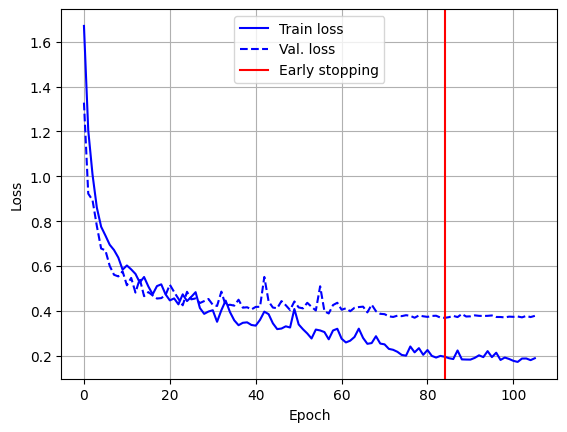

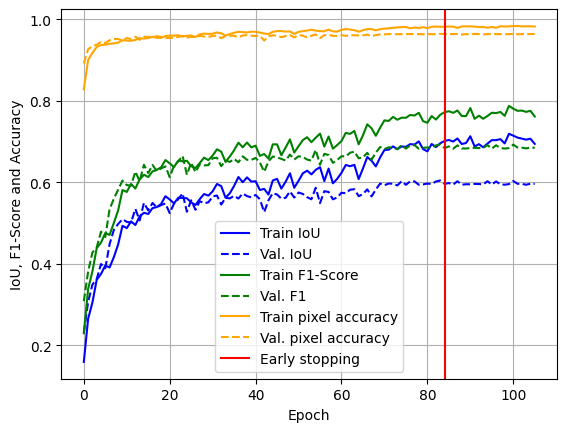

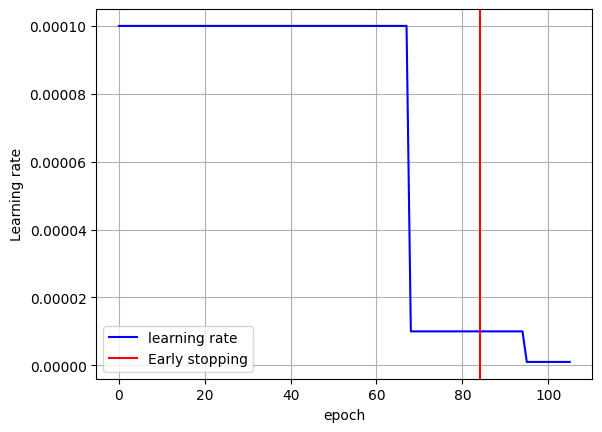

In [38]:
# Plot and save training/validation loss history
plot_loss(history)
plt.savefig(os.path.join(EXP_PATH, 'loss_history.png')) 
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf')) 
### plt.close()

# Plot and save segmentation metrics (IoU, F1-Score, Accuracy) history
plot_score_smp(history)
plt.savefig(os.path.join(EXP_PATH, 'smp_history.png')) 
plt.savefig(os.path.join(EXP_PATH, 'smp_history.pdf')) 
### plt.close()

# Plot and save learning rate schedule
plot_lr(history)
plt.savefig(os.path.join(EXP_PATH, 'lr_history.png')) 
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf')) 
### plt.close()

## 📊 Model Evaluation and Metrics Analysis

In [39]:
def visualize_image(image, mean, std):
    """
    Unnormalizes a torch image tensor and converts it to a NumPy array for visualization.

    Args:
        image (torch.Tensor): Normalized image tensor on GPU or CPU, shape (C, H, W) or (1, C, H, W).
        mean (list of float): Mean values used for normalization, per channel.
        std (list of float): Standard deviation values used for normalization, per channel.

    Returns:
        np.ndarray: Unnormalized image in NumPy format with shape (H, W, C) and values clipped to [0, 1].

    Notes:
        - This function assumes the input was normalized as (t - mean) / std.
        - Only the first 3 channels are visualized (RGB), even if more channels are present.
        - Suitable for displaying images with matplotlib or saving with image libraries.
    """
    # Remove batch dimension if present: (1, C, H, W) → (C, H, W)
    if image.ndim > 3:
        image = image.squeeze(0)

    # Unnormalize each channel using: (x * std) + mean
    # The normalization code is t.sub_(m).div_(s)
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)

    # Move to CPU and convert to NumPy array (float)
    image = image.cpu().numpy().astype(float)

    if image.shape[0] == 1:
        # Grayscale (1, H, W)
        image = image[0]  # → (H, W)
    elif image.shape[0] >= 3:
        # RGB or multispectral: use first 3 channels
        image = image[0:3,:,:]
        # Convert from (C, H, W) to (H, W, C) for visualization
        image = image.transpose((1,2,0))

    # Clip values to valid range [0, 1]
    image = np.clip(image, 0, 1)

    return image

In [40]:
def gen_segmap_binary(img_gt, img_pred):
    """
    Generates a color-coded segmentation map for binary classification tasks,
    highlighting True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN).

    Args:
        img_gt (np.ndarray): Ground truth binary mask (values 0 or 1), shape (H, W).
        img_pred (np.ndarray): Predicted binary mask (values 0 or 1), shape (H, W).

    Returns:
        np.ndarray: RGB segmentation map (H, W, 3) with:
            - True Positive (TP): Green       [0, 255, 0]
            - True Negative (TN): Black       [0, 0, 0]
            - False Positive (FP): Orange     [255, 127, 0]
            - False Negative (FN): Red        [255, 0, 0]

    Notes:
        - Assumes binary masks with values in {0, 1}.
    """
    # Encode pixel-wise combinations
    img_combined = (img_gt.astype(int) * 2) + img_pred.astype(int)

    # Initialize RGB segmentation map (black by default)
    seg_map = np.zeros((*img_combined.shape, 3), dtype=np.uint8)

    # FN (1): Red
    seg_map[img_combined == 1] = [255, 0, 0]
    # TP (3): Green
    seg_map[img_combined == 3] = [0, 255, 0]
    # FP (2): Orange (R=255, G=127, B=0)
    seg_map[img_combined == 2] = [255, 127, 0]
    # TN (0): stays black [0, 0, 0]

    return seg_map

In [41]:
def gen_segmap_multiclass(gt_mask, pred_mask, class_colors, mode='simple', factor=0.4):
    """
    Generates segmentation maps for multiclass prediction visualization.

    Args:
        gt_mask (np.ndarray): Ground truth label mask, shape (H, W), values are class indices.
        pred_mask (np.ndarray): Predicted label mask, shape (H, W), values are class indices.
        class_colors (dict): Dictionary mapping class index to RGB color, e.g., {0: [255, 0, 0]}.
        mode (str, optional): Visualization mode:
            - 'simple': Correct → Green, Incorrect → Red.
            - 'gray': Correct → True class color, Incorrect → Gray.
            - 'darker': Correct → True class color, Incorrect → Darker version of true class color.
        factor (float, optional): Darkening factor for 'darker' mode. Default is 0.4.

    Returns:
        gt_vis (np.ndarray): Ground truth mask visualized in RGB (H, W, 3).
        pred_vis (np.ndarray): Prediction mask visualized in RGB (H, W, 3).
        seg_map (np.ndarray): Colored segmentation difference map based on selected mode (H, W, 3).
    """
        
    H, W = gt_mask.shape
    gt_vis = np.zeros((H, W, 3), dtype=np.uint8)
    pred_vis = np.zeros((H, W, 3), dtype=np.uint8)
    seg_map = np.zeros((H, W, 3), dtype=np.uint8)

    # Colorize ground truth mask
    for cls, color in class_colors.items():
        gt_vis[gt_mask == cls] = color

    # Colorize predicted mask
    for cls, color in class_colors.items():
        pred_vis[pred_mask == cls] = color

    # Boolean mask for correct predictions (TP)
    correct = pred_mask == gt_mask
    seg_map[correct] = [0, 255, 0]

    if mode == 'simple':
        # Incorrect predictions: Red
        incorrect = ~correct
        seg_map[incorrect] = [255, 0, 0]

    elif mode == 'gray':
        # Correct → true class color, Incorrect → gray
        correct = (gt_mask == pred_mask)
        incorrect = ~correct

        for cls, color in class_colors.items():
            rows, cols = np.where(correct & (gt_mask == cls))
            seg_map[rows, cols] = color

        # Errors → gray
        rows, cols = np.where(incorrect)
        seg_map[rows, cols] = [127, 127, 127] # Gray

    elif mode == 'darker':
         # Correct → true class color, Incorrect → darker version of true class color
        for cls, color in class_colors.items():
            mask_tp = (gt_mask == cls) & (pred_mask == cls)  # True positives
            mask_err = (gt_mask == cls) & (pred_mask != cls)  # Errors (wrong prediction)

            rows_tp, cols_tp = np.where(mask_tp)
            rows_err, cols_err = np.where(mask_err)

            seg_map[rows_tp, cols_tp] = color
            seg_map[rows_err, cols_err] = np.clip(
                np.array(color) * factor, 0, 255
            ).astype(np.uint8)

    else:
        raise ValueError(f"Unknown mode '{mode}'. Choose from 'simple', 'gray', or 'darker'.")        

    return gt_vis, pred_vis, seg_map

In [42]:
def evaluate_model_per_image(model, dataloader, mode='val', reduction='macro'):
    """
    Evaluates the segmentation model per image using SMP metrics.

    Args:
        model (torch.nn.Module): Trained model to evaluate.
        dataloader (DataLoader): DataLoader providing images, masks, and file paths.
        mode (str): Mode for saving outputs (e.g., 'val', 'test').
        reduction (str): Reduction strategy for metrics ('macro' or 'micro').

    Returns:
        path_list (list): List of image file paths.
        smp_metrics_per_image (dict): Dictionary with metric values per image.
        smp_metrics_stats (dict): Dictionary with aggregated (mean/std) metrics.
    
    Notes:
        - Supports both binary and multiclass segmentation.
        - Optionally saves prediction visualizations and segmentation maps.
    """
    print(f'\nEvaluating model per-image in "{mode}" mode with "{reduction}" reduction...')    

    path_list = []

    # For image-wise metrics
    smp_metrics_per_image = {
        'iou': [],
        'f1': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
    }
    
    model.eval()
    model.to(device)

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            image, mask, path = data

            image = image.float().to(device)
            mask = mask.to(device)

            # Forward pass
            output = model(image)

             # DEBUG
            if args.debug and i == 0:
                print(f'\n[DEBUG] Checkpoint A:')
                print(f'Output shape: {output.shape} | Output dtype: {output.dtype}')
                print(f'Mask shape: {mask.shape} | Mask dtype: {mask.dtype}')

            # Preprocess predictions and masks for metrics
            if args.n_classes == 1:  
                # Binary mode. Output should be (B, 1, H, W) and dtype float
                pred = (torch.sigmoid(output) > 0.5).float()
                if pred.ndim == 3:  # (B, H, W) → (B, 1, H, W)
                    pred_mask = pred.unsqueeze(1) 
                else:
                    pred_mask = pred

                if mask.ndim == 3: # (B, H, W) → (B, 1, H, W)
                    mask = mask.unsqueeze(1)  

            else:  
                # Multiclass mode. Output should be (B, H, W) and dtype long
                pred_mask = torch.argmax(output, dim=1)  # (B, H, W)
                if mask.ndim == 4 and mask.shape[1] == 1:
                    mask = mask.squeeze(1)  # (B, H, W)

            # DEBUG
            if args.debug and i == 0:
                print(f'\n[DEBUG] Checkpoint B:')
                print(f'Output shape: {output.shape} | Output dtype: {output.dtype}')
                print(f'Mask shape: {mask.shape} | Mask dtype: {mask.dtype}')
                print(f'Pred shape: {pred_mask.shape} | Pred dtype: {pred_mask.dtype}')

            # Get SMP stats (TP, FP, FN, TN)
            if args.n_classes == 1:  # binary
                # PRED_MASK: (B, 1, H, W). MASK: (B, 1, H, W) and dtype long.
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_mask.cpu(), mask.long().cpu(), mode='binary', threshold=0.5
                )
            else:
                # PRED_MASK: (B, H, W). MASK: (B, H, W) and dtype long.
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_mask.cpu(), mask.long().cpu(), mode='multiclass', num_classes=args.n_classes
                )

            # Per-image metrics collection
            for j, (tp_, fp_, fn_, tn_, path_) in enumerate(zip(tp, fp, fn, tn, path)):
                # Store the image path.
                path_list.append(path_)

                # TP, FP, FN, TN: (B, 1) if `binary`, (B, C) if `multiclass`. 
                # Insert back the batch dimension.
                tp_ = tp_.unsqueeze(0); fp_ = fp_.unsqueeze(0); fn_ = fn_.unsqueeze(0); tn_ = tn_.unsqueeze(0)

                # Compute metrics using SMP
                for name, fn_metric in {
                    'iou': smp.metrics.functional.iou_score,
                    'f1': smp.metrics.functional.f1_score,
                    'accuracy': smp.metrics.functional.accuracy,
                    'precision': smp.metrics.functional.precision,
                    'recall': smp.metrics.functional.recall
                }.items():
                    value = fn_metric(tp_, fp_, fn_, tn_, reduction=reduction).item()
                    smp_metrics_per_image[name].append(value)

            # Save outputs
            # ------------
            if args.save_images:
                for j, (pred_, mask_, image_, path_) in enumerate(zip(pred_mask, mask, image, path)):
                    # Get original filename.
                    img_filename = str(path_).split('/')[-1]
                    # Ensure extension is PNG.
                    img_filename = os.path.splitext(img_filename)[0] + '.png'

                    pred_ = pred_.squeeze().cpu().numpy().astype(np.uint8)
                    mask_ = mask_.squeeze().cpu().numpy().astype(np.uint8)

                    if args.n_classes == 1: # Binary segmentation
                        # Save prediction
                        pred_pil = Image.fromarray(pred_ * 255)
                        pred_pil.save(os.path.join(EXP_PATH, f'{mode}_pred', img_filename))
                        # Save mask
                        mask_pil = Image.fromarray(mask_ * 255)
                        mask_pil.save(os.path.join(EXP_PATH, f'{mode}_true', img_filename))
                        # Save segmentation map
                        seg_map = gen_segmap_binary(mask_, pred_)
                        Image.fromarray(seg_map).save(os.path.join(EXP_PATH, f'{mode}_seg_map', img_filename))
                    
                    else: # Multiclass segmentation
                        # Get visualizations for mask, predictions and segmentation map.
                        mask_vis, pred_vis, seg_map = gen_segmap_multiclass(mask_, pred_, class_to_rgb, mode=args.segmap_mode)
                        # Save the segmentation map
                        Image.fromarray(seg_map).save(os.path.join(EXP_PATH, f'{mode}_seg_map', img_filename))
                        # Save mask
                        mask_pil = Image.fromarray(mask_vis)
                        mask_pil.save(os.path.join(EXP_PATH, f'{mode}_true', img_filename))
                        # Save prediction
                        pred_pil = Image.fromarray(pred_vis)
                        pred_pil.save(os.path.join(EXP_PATH, f'{mode}_pred', img_filename))

                    # Save the input image
                    # --------------------
                    image_ = visualize_image(image_, MEAN, STD)
                    image_ = img_as_ubyte(image_)
                    Image.fromarray(image_).save(os.path.join(EXP_PATH, f'{mode}_images', img_filename))

    # Compute aggregated statistics (mean and std) for metrics
    smp_mean_stats = {name: float(np.mean(vals)) for name, vals in smp_metrics_per_image.items()}
    smp_std_stats = {name: float(np.std(vals)) for name, vals in smp_metrics_per_image.items()}
    smp_metrics_stats = {
        "mean": smp_mean_stats,
        "std": smp_std_stats
    }

    print(f'Model evaluated per-image in "{mode}" mode!')

    return path_list, smp_metrics_per_image, smp_metrics_stats          

In [43]:
def evaluate_model(model, dataloader, mode='val', reduction='macro'):
    """
    Evaluates the segmentation model over the entire dataset.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        dataloader (torch.utils.data.DataLoader): Dataloader providing (image, mask, path).
        mode (str): Mode used for logging or saving outputs ('val' or 'test').
        reduction (str): Metric reduction type ('macro', 'micro', 'macro-imagewise', or 'micro-imagewise').
            - 'macro': Compute metrics per class, then average.
            - 'micro': Aggregate TP, FP, FN, TN over all classes before computing metrics.

    Returns:
        path_list (list): List of image paths used in the evaluation.
        smp_metrics (dict): Dictionary of aggregated SMP metrics (IoU, F1, Accuracy, Precision, Recall).

    Notes:
        - Uses segmentation_models_pytorch (SMP) metrics.
        - Supports both binary and multiclass segmentation.
    """
    print(f'\nEvaluating model in "{mode}" mode with "{reduction}" reduction...')    

    # Path list
    path_list = []

    # SMP metrics
    all_tp, all_fp, all_fn, all_tn = [], [], [], []

    model.eval()
    model.to(device)

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            image, mask, path = data

            image = image.float().to(device)
            mask = mask.to(device)

            # Forward pass
            output = model(image)

            # Preprocess predictions and masks for metrics
            if args.n_classes == 1:  
                # Binary mode. Output should be (B, 1, H, W) and dtype float
                pred = (torch.sigmoid(output) > 0.5).float()
                if pred.ndim == 3:  # (B, H, W) → (B, 1, H, W) 
                    pred_mask = pred.unsqueeze(1) 
                else:
                    pred_mask = pred

                if mask.ndim == 3: # (B, H, W) → (B, 1, H, W)
                    mask = mask.unsqueeze(1)  

            else:  
                # Multiclass mode. Output should be (B, H, W) and dtype long
                pred_mask = torch.argmax(output, dim=1)  # (B, H, W)
                if mask.ndim == 4 and mask.shape[1] == 1:
                    mask = mask.squeeze(1)  # (B, H, W)

            # Get SMP stats (TP, FP, FN, TN)
            if args.n_classes == 1:  # binary
                # PRED_MASK: (B, 1, H, W). MASK: (B, 1, H, W) and dtype long
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_mask.cpu(), mask.long().cpu(), mode='binary', threshold=0.5
                )
            else:
                # PRED_MASK: (B, H, W). MASK: (B, H, W) and dtype long
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_mask.cpu(), mask.long().cpu(), mode='multiclass', num_classes=args.n_classes
                )

            # Agregate the TP, FP, FN, TN across all batches
            all_tp.append(tp)
            all_fp.append(fp)
            all_fn.append(fn)
            all_tn.append(tn)

            path_list.extend(path)
 
    # Concatenate all TP, FP, FN, TN across batches
    tp_sum = torch.cat(all_tp)
    fp_sum = torch.cat(all_fp)
    fn_sum = torch.cat(all_fn)
    tn_sum = torch.cat(all_tn)

    # Compute aggregated metrics using SMP
    smp_metrics = {
        f'iou': smp.metrics.functional.iou_score(tp_sum, fp_sum, fn_sum, tn_sum, reduction=reduction).item(),
        f'f1': smp.metrics.functional.f1_score(tp_sum, fp_sum, fn_sum, tn_sum, reduction=reduction).item(),
        f'accuracy': smp.metrics.functional.accuracy(tp_sum, fp_sum, fn_sum, tn_sum, reduction=reduction).item(),
        f'precision': smp.metrics.functional.precision(tp_sum, fp_sum, fn_sum, tn_sum, reduction=reduction).item(),
        f'recall': smp.metrics.functional.recall(tp_sum, fp_sum, fn_sum, tn_sum, reduction=reduction).item(),
    }

    print(f'Model evaluated in "{mode}" mode!')

    return path_list, smp_metrics 

In [44]:
def save_smp_metrics_per_image_csv(file_paths, metrics_dict, stats_dict, output_csv):
    """
    Saves per-image segmentation metrics and aggregated statistics to a CSV file.

    Args:
        file_paths (list of str): List of image file paths.
        metrics_dict (dict): Dictionary with metric names as keys and lists of per-image values.
        stats_dict (dict): Dictionary with keys 'mean' and 'std', each containing a dict of aggregated metrics.
        output_csv (str): Path to save the output CSV file.

    Raises:
        ValueError: If the number of metric values does not match the number of file paths.
    """
    # Validate metric lengths
    num_files = len(file_paths)
    for metric, values in metrics_dict.items():
        if len(values) != num_files:
            raise ValueError(f"Metric '{metric}' has {len(values)} values, expected {num_files}.")

    # CSV header: Index, File Path, Metric Columns
    header = ["#", "File Path"] + list(metrics_dict.keys())

    with open(output_csv, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(header)

        # Write per-image metric rows
        for idx, path in enumerate(file_paths):
            row = [idx, path.removeprefix(os.path.expanduser('~/Datasets/'))] # Remove home directory prefix
            for metric in metrics_dict.keys():
                row.append(metrics_dict[metric][idx])
            writer.writerow(row)

        # Write Mean row
        mean_row = ["", "Mean"]
        for metric in metrics_dict.keys():
            mean_value = stats_dict['mean'].get(metric, "")
            mean_row.append(mean_value)
        writer.writerow(mean_row)

        # Write Std Dev row
        std_row = ["", "Std Dev"]
        for metric in metrics_dict.keys():
            std_value = stats_dict['std'].get(metric, "")
            std_row.append(std_value)
        writer.writerow(std_row)

In [45]:
def save_smp_metrics_csv(metrics_dict, output_csv, reduction):
    """
     Saves aggregated SMP evaluation metrics to a CSV file.

    Args:
        metrics_dict (dict): Dictionary where keys are metric names (e.g., 'iou', 'f1') and values are scalar results.
        output_csv (str): Path to the output CSV file.
        reduction (str): Reduction method used for evaluation ('macro', 'micro', 'macro-imagewise', 'micro-imagewise').
    """
    # Header row: Reduction + metric names
    header = [f'Reduction'] + list(metrics_dict.keys())

    with open(output_csv, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(header)

        # Write rows for each image
        row = [f'{reduction}']
        for metric in metrics_dict.keys():
            row.append(metrics_dict[metric])
        writer.writerow(row)

## 📝 Summary Report Generation

In [46]:
def gen_general_rep(smp_metrics, smp_metrics_iw, mode='val', reduction='macro'):
    """
    Generates or appends a general CSV report with aggregated and image-wise metrics.

    Args:
        smp_metrics (dict): Aggregated metrics (global evaluation) from SMP, e.g., {'iou': 0.75, 'f1': 0.82}.
        smp_metrics_iw (dict): Image-wise metrics aggregated (mean or std), e.g., {'iou': 0.70, 'f1': 0.78}.
        mode (str): Dataset evaluation mode ('val' or 'test'). Used for report file naming.
        smp_reduction (str): Reduction method used for metrics ('macro' or 'micro').

    Notes:
        - Creates the CSV on first epoch (args.ec == 0) with header.
        - Appends data for subsequent epochs.
        - Columns include experiment config + metrics + image-wise metrics.
    """
    print('Generating general report...')
    # O nome de um arquivo CSV. Irá armazenar todos os losses e acuracias.
    filename = os.path.join(EXP_PATH_MAIN, f'gen_report_({mode})_({reduction}).csv')

    if args.ec == 0:
        # Create a new CSV with header on first execution cycle
        file = open(filename, 'w')
        writer = csv.writer(file, delimiter=';')

        smp_metrics_iw_keys = list(smp_metrics_iw.keys())
        smp_metrics_iw_keys = [s + '-iw' for s in smp_metrics_iw_keys]

        # Cria cabeçalho
        header = [
             '#','DS','MODEL','ENCODER','FT','BS','LR','EP','SCHEDULER','ES','LOSS', 'DA'
        ] + list(smp_metrics.keys()) + smp_metrics_iw_keys
        
        writer.writerow(header)

    else:
        # Append mode for subsequent executions
        file = open(filename, 'a')
        writer = csv.writer(file, delimiter=';')

    # Write experiment info and metrics
    info = [args.ec, args.dataset_name, args.model, args.backbone, args.pretrained, args.batch_size, 
            args.lr, args.max_epochs, args.scheduler, best_epoch, args.loss, args.da_train]

    for metric in smp_metrics.keys():
        info.append(smp_metrics[metric])

    for metric in smp_metrics_iw.keys():
        info.append(smp_metrics_iw[metric])

    writer.writerow(info)

    # Close the file
    file.close()

## 🧪 Final Model Evaluation

In [47]:
def run_model_evaluation(data_loader, mode='test', reduction='macro', gen_rep=True):
    """
    Runs the full evaluation pipeline for a trained segmentation model.

    Args:
        data_loader (DataLoader): DataLoader containing the dataset for evaluation.
        mode (str): Evaluation mode ('val' or 'test'). Used for naming reports.
        reduction (str): Reduction strategy for SMP metrics ('macro' or 'micro').
        gen_rep (bool): Whether to update the general experiment report.

    Notes:
        - Evaluates per-image metrics (detailed) and saves per-image CSV.
        - Evaluates global dataset metrics with the selected reduction and saves CSV.
        - Evaluates dataset metrics with 'imagewise' reduction and saves CSV.
        - Updates the consolidated general report if enabled.
    """

    # 1 — Per-image evaluation with detailed metrics per sample
    # In this case: 'micro' = 'micro-imagewise' and 'macro' = 'macro-imagewise'
    path_list, smp_metrics_per_image, smp_metrics_stats = \
        evaluate_model_per_image(model, data_loader, mode=mode, reduction=reduction)
    
    save_smp_metrics_per_image_csv(path_list, smp_metrics_per_image, smp_metrics_stats, os.path.join(EXP_PATH, f'report_smp_({mode})_imagewise_({reduction}).csv'))

    # 2 — Global evaluation over the dataset (aggregated metrics)
    # If binary segmentation: 'macro' = 'micro'
    path_list, smp_metrics = \
        evaluate_model(model, data_loader, mode=mode, reduction=reduction)

    save_smp_metrics_csv(smp_metrics, os.path.join(EXP_PATH, f'report_smp_({mode})_({reduction}).csv'), reduction)

    # 3 — Global evaluation with imagewise reduction strategy
    # If binary segmentation: 'macro-imagewise' = 'micro-imagewise'
    reduction_ = reduction + '-imagewise'
    path_list, smp_metrics_iw = \
        evaluate_model(model, data_loader, mode=mode, reduction=reduction_)

    save_smp_metrics_csv(smp_metrics_iw, os.path.join(EXP_PATH, f'report_smp_({mode})_({reduction_}).csv'), reduction_)   

    # 4 — Update the global experiment report if enabled
    if gen_rep:
        gen_general_rep(smp_metrics, smp_metrics_iw, mode=mode, reduction=reduction)   

In [48]:
if eval_val:
    # Create output folders for saving evaluation results
    folders = ['val_images', 'val_true', 'val_pred', 'val_seg_map']
    for folder in folders:
        os.makedirs(os.path.join(EXP_PATH, folder), exist_ok=True)

    # Run evaluation in 'macro' and 'macro-imagewise' reduction mode.
    run_model_evaluation(val_loader, mode='val', reduction='macro')
    # Run evaluation in 'micro' ans 'micro-imagewise' reduction mode.
    run_model_evaluation(val_loader, mode='val', reduction='micro')

In [49]:
# Create output folders for saving evaluation results
folders = ['test_images', 'test_true', 'test_pred', 'test_seg_map']
for folder in folders:
    os.makedirs(os.path.join(EXP_PATH, folder), exist_ok=True)

# Run evaluation in 'macro' and 'macro-imagewise' reduction mode.
run_model_evaluation(test_loader, mode='test', reduction='macro')
# Run evaluation in 'micro' ans 'micro-imagewise' reduction mode.
run_model_evaluation(test_loader, mode='test', reduction='micro')


Evaluating model per-image in "test" mode with "macro" reduction...
Model evaluated per-image in "test" mode!

Evaluating model in "test" mode with "macro" reduction...
Model evaluated in "test" mode!

Evaluating model in "test" mode with "macro-imagewise" reduction...
Model evaluated in "test" mode!
Generating general report...

Evaluating model per-image in "test" mode with "micro" reduction...
Model evaluated per-image in "test" mode!

Evaluating model in "test" mode with "micro" reduction...
Model evaluated in "test" mode!

Evaluating model in "test" mode with "micro-imagewise" reduction...
Model evaluated in "test" mode!
Generating general report...


## ✅ Finish!

In [50]:
print('\nFinish!')


Finish!
